機械学習のフロー
1.この課題の目的

機械学習の実践的な流れを知る
高い汎化性能を持つモデルを完成させる

1回目のSprintでは、機械学習の実践的な流れを抑えます。このSprintはWeek3,4の延長になり、引き続きKaggleの Home Credit Default Risk コンペティションを用います。特にここでは適切な 検証 を組み込むことを重視し、その上で前処理やモデルの選定を進めていきます。


適切な検証を行い、テストデータに対して高い汎化性能を持つモデルを完成させましょう。


【問題1】クロスバリデーション
事前学習期間は検証データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。


具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。


sklearn.model_selection.KFold — scikit-learn 0.20.2 documentation




In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools
%matplotlib inline

df = pd.read_csv('/content/drive/MyDrive/DIC/application_train.csv', encoding='SHIFT-JIS', index_col=0)
# df = pd.read_csv("test.csv", encoding='SHIFT-JIS', index_col=0)
df = df.drop(columns=df.select_dtypes(include='object').columns)
df = df.dropna(how='any')
df = df.dropna(how='any', axis=1)
# print(df)
# print(df.head(20))
print(len(df))
# print("デフォルトは先頭5行分が出力される。")
# s = '\n'
# print(s)
print(df.info())


x=df.loc[:,['AMT_INCOME_TOTAL','AMT_ANNUITY']]
y = df.loc[:, ['TARGET']]


11351
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11351 entries, 100083 to 456226
Columns: 105 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40)
memory usage: 9.2 MB
None


In [36]:
########################
# ロジスティック回帰
########################
#from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import random
from sklearn import metrics

# LinearRegression
# clf = LogisticRegression()
#Logi_model.fit(X_train, Y_train)


########################
# クロスバリデーション
########################

# 交差検証（Cross-validation）です．

# 交差検証では，データセットを kk 個に分割し，モデルの訓練と評価を kk 回行います．
# 得られた kk 個の評価値の平均をとった値を最終的なモデルのスコアとして扱います．

from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
 
# def evaluate_cross_validation(clf, x, y, K):
#     cv = KFold(len(y), K,shuffle=True,random_state=0)
#     scores = cross_val_score(clf,x,y,cv=cv)
#     print(scores)
#     print ("Mean score: {} (+/-{})".format( np.mean (scores), sem(scores)))


# # x=df.loc[:,['AMT_INCOME_TOTAL','AMT_ANNUITY']]
# # y = df.loc[:, ['TARGET']]
# # K=3
# evaluate_cross_validation


from sklearn.model_selection import cross_val_score
logreg = LogisticRegression()
# 交差検証
# scores = cross_val_score(logreg, iris.data, iris.target)
scores = cross_val_score(logreg, x, y,cv=3)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.9397463  0.93948203 0.93973037]
Average score: 0.9396529008432628


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


【問題2】グリッドサーチ
これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。


グリッドサーチをパイプラインの中に組み込みましょう。

In [37]:
########################
# SVCとグリッドサーチ
########################

# グリッドサーチ（grid search）です．

# これは指定したパラメータの全ての組み合わせに対して学習を行い，もっとも良い精度を示したパラメータを採用する方法です．


from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

'''
gamma と C に対して，それぞれ 0.001, 0.01, 0.1, 1, 10, 100 を試してみることにすると，
6×6=366×6=36 通りの組合せが存在することになります．

グリッドサーチでは，この 36 通りの組合せすべてについてモデルの学習と評価を行います．
param_list = [0.001, 0.01, 0.1, 1, 10, 100]
'''
param_list = [0.001, 0.01, 0.1, 1, 10, 100]
best_score = 0
best_parameters = {}

for gamma in param_list:
    for C in param_list:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        # 最も良いスコアのパラメータとスコアを更新
        if score > best_score:
            best_score = score
            best_parameters = {'gamma' : gamma, 'C' : C}

print('Best score: {}'.format(best_score))
print('Best parameters: {}'.format(best_parameters))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best score: 0.9376321353065539
Best parameters: {'gamma': 0.001, 'C': 0.001}


【問題3】Kernelからの調査
KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。



In [38]:
# ＃-重要な機能を除算または減算して、レート（年金や収入など）を取得します
# ＃-ビューローデータ内：アクティブクレジットとクローズドクレジットの特定の機能を作成します
# ＃-以前のアプリケーションの場合：承認および拒否されたアプリケーション用の特定の機能を作成します
# ＃-モジュール性：テーブルごとに1つの関数（bureau_balanceとapplication_testを除く）
# ＃-カテゴリ機能のワンホットエンコーディング
# ＃すべてのテーブルは、SK_ID_CURRキーを使用してアプリケーションDFと結合されます（bureau_balanceを除く）。
# ＃LightGBMはKFoldまたはStratifiedKFoldで使用できます。
# # モデルの機能や特徴量を調節して予測の向上を目指す。

#この中で、効果がありそうな、新たなアイデアである８について検証した。
#【結論】特徴量で重要なのを見つけてグラフ化し、'EXT_SOURCE_3'を追加した。そうすると、指標指数が、0.55から0.56に向上した。


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5417872479462286

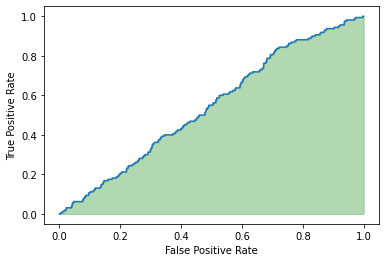

In [39]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/DIC/application_train.csv', encoding='SHIFT-JIS', index_col=0)
df = df.drop(columns=df.select_dtypes(include='object').columns)
df = df.dropna(how='any')
df = df.dropna(how='any', axis=1)
# print(df)
# print(df.head(20))
# print(len(df))
# print(df.info())


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools


X=df.loc[:,['AMT_INCOME_TOTAL','AMT_ANNUITY']]

target = df.loc[:, ['TARGET']]

########################
# ロジスティック回帰
########################
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import random
from sklearn import metrics

# トレーニング・テストデータ分割
X_train, X_test, Y_train, Y_test = train_test_split(X, target, train_size= 0.75, test_size=0.25)

# LinearRegression
Logi_model = LogisticRegression()
Logi_model.fit(X_train, Y_train)


#ROC曲線で評価する

# 予測　
Y_pred = Logi_model.predict(X_test)
Y_proba = Logi_model.predict_proba(X_test)

#ROC曲線の描画

fpr,tpr,threshold = metrics.roc_curve(Y_test,Y_proba[:,1])
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr,tpr,color='g',alpha=0.3)

metrics.auc(fpr,tpr)
# plt.xlabel("RM")
# plt.ylabel("Target")
# plt.plot(X_test, Y_pred, "r-")
# plt.plot(X_test, Y_test, "o")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


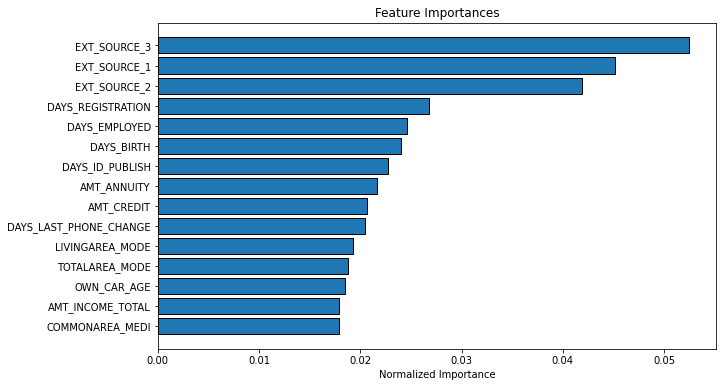

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5408170057913773

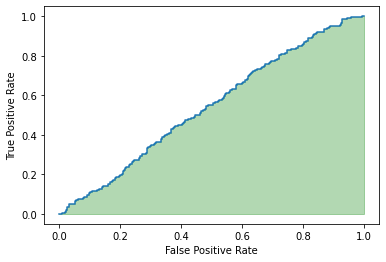

In [40]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/DIC/application_train.csv', encoding='SHIFT-JIS', index_col=0)
df = df.drop(columns=df.select_dtypes(include='object').columns)
df = df.dropna(how='any')
df = df.dropna(how='any', axis=1)
# print(df)
# print(df.head(20))
# print(len(df))
# print(df.info())


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools
import math



# モデルの機能重要性
# モデルの機能や特徴量を調節して予測の向上を目指す。



def plot_feature_importances(df):
    """
    モデルから重要度を抽出する。より重要度が高い方がいい。
    
    引数
        df (dataframe): 特徴量の輸入量。カラム名は `features` というカラムに、重要度は`importance`と呼ばれる列に格納する必要がある。
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
      戻り値
        最も重要な15個のフィーチャーを表示します。
        
        df (dataframe): 重要度でソートされた特徴量 (最高から最低) 
        重要度は正規化される
        """
    
    # 重要度昇順でカラムを並び替え
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # 正規化
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # 重要度をカラムごとに可視化する
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # 重要度が高いカラムから横棒グラフを作成する。
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # y軸にメモリとカラム名を追加
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # 図表を表示
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df




from sklearn.ensemble import RandomForestClassifier

# ランダムフォレスト分類子を作成する
#n_estimators: 木の数　大きい程制度がよくなるがその分学習に時間がかかる
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
# target行を削除
if 'TARGET' in df:
    #返り値で何かを返しているわけではない
    train = df.drop(columns = ['TARGET'])
else:
    train = df.copy()
# Feature ＝カラム名リスト
features = list(train.columns)


#TARGETカラムはテストデータにないが削除してはいけないカラムなので一度変数に格納しておいて後から再度追加する
train_labels = df['TARGET']
# 分類子を学習させる
random_forest.fit(train, train_labels)
# カラムごとの重要度をリストに格納する
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

X=df.loc[:,['AMT_INCOME_TOTAL','AMT_ANNUITY','EXT_SOURCE_3']]
# X1=df.loc[:,['AMT_INCOME_TOTAL']]
# X2=df.loc[:,['AMT_CREDIT']]

# print(X1)
# print(X2)
# print(X1.isnull().sum())
# print(X2.isnull().sum())
# X_test=X2
# test_mean=X_test.copy()
# print(test_mean['AMT_CREDIT'].mean())
# test_mean['AMT_CREDIT'] = test_mean['AMT_CREDIT'].fillna(test_mean['AMT_CREDIT'].mean())
# print(test_mean.isnull().sum())
# test_mean=math.floor(test_mean)
# print(test_mean.round().astype(int))
# print(X1.round().astype(int))
# X=(X1.round().astype(int))/(test_mean.round().astype(int))
# print(X.isnull().sum())
# X=X.round().astype(int)
# print(df['AMT_INCOME_TOTAL'])
# print(df['AMT_CREDIT'])
# df['X1']=df['AMT_INCOME_TOTAL']/df['AMT_CREDIT']
# print(dfX1)

# # print(df['AMT_INCOME_TOTAL'])
# # print(df['AMT_CREDIT'])
# df['X2']=df['AMT_INCOME_TOTAL']/df['AMT_ANNUITY']
# print(dfX2)

# X=pd.concat[dfX1,dfX2]
# print(X)
target = df.loc[:, ['TARGET']]

########################
# ロジスティック回帰
########################
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import random
from sklearn import metrics

# トレーニング・テストデータ分割
X_train, X_test, Y_train, Y_test = train_test_split(X, target, train_size= 0.75, test_size=0.25)

# LinearRegression
Logi_model = LogisticRegression()
Logi_model.fit(X_train, Y_train)


#ROC曲線で評価する

# 予測　
Y_pred = Logi_model.predict(X_test)
Y_proba = Logi_model.predict_proba(X_test)

#ROC曲線の描画

fpr,tpr,threshold = metrics.roc_curve(Y_test,Y_proba[:,1])
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr,tpr,color='g',alpha=0.3)

metrics.auc(fpr,tpr)


【問題4】高い汎化性能のモデル
これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

In [41]:
#高い汎化性能のモデルを調べると、ニューラルネットワークがあるので、これで、今回のでkaggleデータ使用して検証しました。

#モデルの宣言
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(random_state=0, max_iter=300)


import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/DIC/application_train.csv', encoding='SHIFT-JIS', index_col=0)
df = df.drop(columns=df.select_dtypes(include='object').columns)
df = df.dropna(how='any')
df = df.dropna(how='any', axis=1)
# print(df)
# print(df.head(20))
# print(len(df))
# print(df.info())


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools


X=df.loc[:,['AMT_INCOME_TOTAL','AMT_ANNUITY']]

target = df.loc[:, ['TARGET']]

# トレーニング・テストデータ分割
X_train, X_test, Y_train, Y_test = train_test_split(X, target, train_size= 0.75, test_size=0.25)

#モデルの学習
model.fit(X_train,Y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [42]:
MLPClassifier(max_iter=300,random_state=0)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [43]:
#モデルの検証
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.9398566897685893
0.9390415785764623
